<a href="https://colab.research.google.com/github/Mounish2023/fastaicourse/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *

# simple training

In [2]:
path = untar_data(URLs.PETS)

In [3]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [4]:
(path/'/root/.fastai/data/oxford-iiit-pet/images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_18.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_43.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_190.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_124.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_97.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_160.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_201.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_95.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_48.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_126.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_122.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bengal_61.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_112.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_4.jpg'

In [5]:
fname = (path/'/root/.fastai/data/oxford-iiit-pet/images').ls()[0]
fname

Path('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_18.jpg')

In [6]:
fname.name

'chihuahua_18.jpg'

In [7]:
pattern = r'(.+)_\d+\.jpg'

In [8]:
import re
re.findall(pattern,fname.name)

['chihuahua']

In [9]:
fnames = (path/'/root/.fastai/data/oxford-iiit-pet/images').ls()


In [10]:
all_names = []
for f in fnames:
  all_names.append(re.findall(pattern, f.name))

In [11]:
all_names[4]

['Egyptian_Mau']

In [12]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(seed=42),
    item_tfms=Resize(460),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+\.jpg$'),'name'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [13]:
dls = pets.dataloaders(path/'/root/.fastai/data/oxford-iiit-pet/images')

In [14]:
len(dls)

2

In [15]:
dls.bs

64

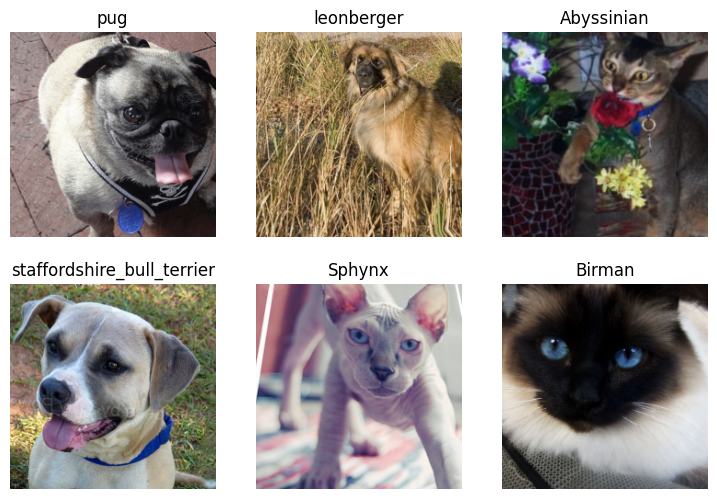

In [16]:
dls.train.show_batch(max_n=6,nrows=2)

In [17]:
pets.summary(path/'/root/.fastai/data/oxford-iiit-pet/images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bombay_181.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x225
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Bombay_181.jpg
    applying partial gives
      Bombay
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=300x225, TensorCategory(3))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: 

In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 169MB/s]


In [19]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.514715,0.317330,0.099459,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.497743,0.382331,0.117727,01:14
1,0.318196,0.218104,0.071719,01:16


In [20]:
x,y = dls.one_batch()

In [21]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

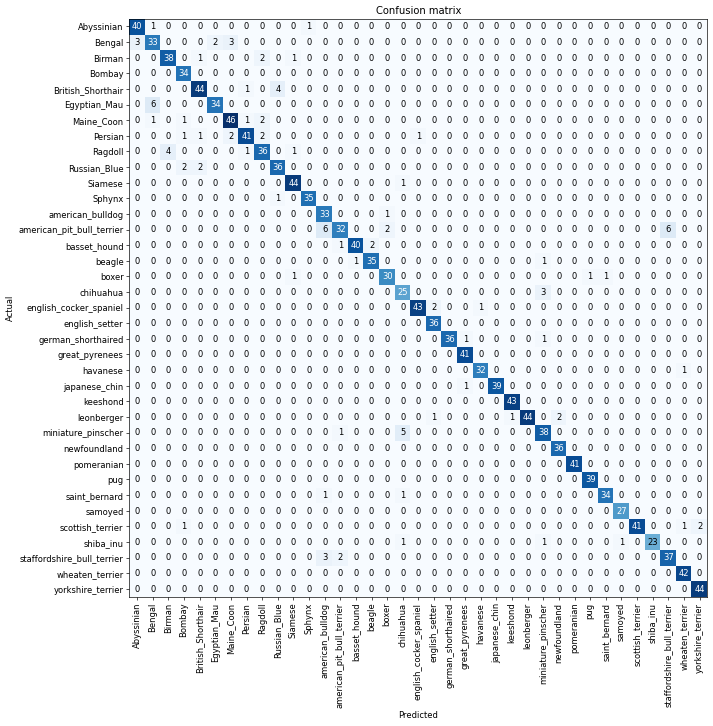

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [23]:
interp.most_confused(min_val=5)

[('Egyptian_Mau', 'Bengal', np.int64(6)),
 ('american_pit_bull_terrier', 'american_bulldog', np.int64(6)),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', np.int64(6)),
 ('miniature_pinscher', 'chihuahua', np.int64(5))]

# Improving our model

The Learning Rate Finder-

i constructed the model and asked it to find the best possible learning rate. this follows leslie smith approach and plots the graph between loss and learning rate.

chooses the least possible learning rate and runs a mini-batch and computes loss. doubles the learning rate (basically increase it by a certain percentage) and calculate the compute for second batch with the new learning rate and do this until the loss starts increasing.

SuggestedLRs(valley=0.0020892962347716093)

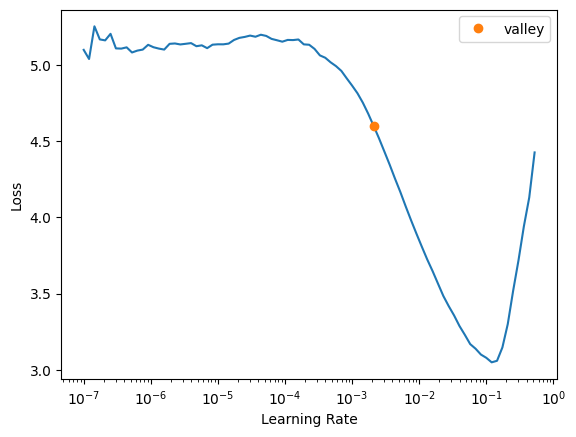

In [24]:
learn_lr_finder = vision_learner(dls, resnet34, metrics=error_rate)
learn_lr_finder.lr_find()

In [25]:
learn_with_best_lr = vision_learner(dls, resnet34, metrics=error_rate)
learn_with_best_lr.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.287245,0.350117,0.108931,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.558106,0.402191,0.118403,01:17
1,0.315911,0.231239,0.073748,01:18


Unfreezing and Transfer learning using fit_one_cycle approach

In [26]:
manual_learn = vision_learner(dls, resnet34, metrics=error_rate)
manual_learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.160495,0.325070,0.100135,01:16
1,0.558183,0.250791,0.073748,01:18
2,0.334109,0.234601,0.071042,01:13


In [27]:
manual_learn.unfreeze()

SuggestedLRs(valley=2.511886486900039e-05)

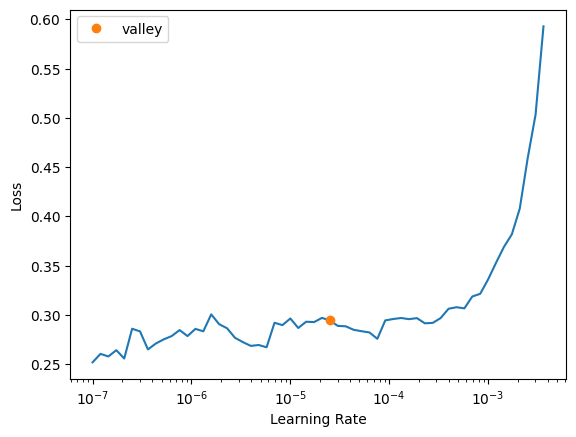

In [28]:
manual_learn.lr_find()

In [29]:
manual_learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.267354,0.227388,0.071042,01:19
1,0.268463,0.209415,0.066982,01:22
2,0.229297,0.208326,0.062246,01:17
3,0.216379,0.203679,0.062246,01:14
4,0.202118,0.200993,0.064276,01:18
5,0.188003,0.200911,0.060217,01:23


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

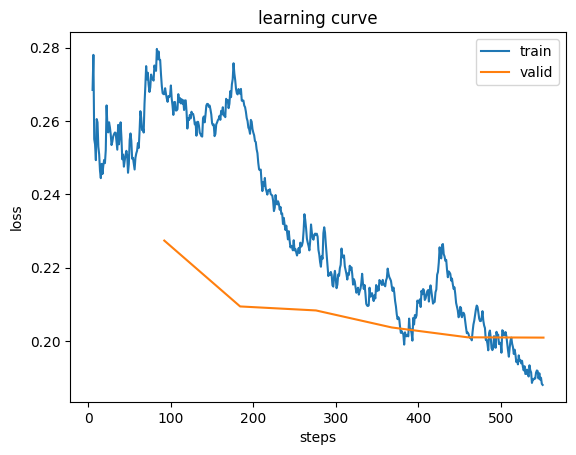

In [31]:
manual_learn.recorder.plot_loss()

**Discriminative Learning rates**:

the best learning rate for those pretrained parameters doesn't have to be same as the newly added layers.

the pretrained weights has learnt a lot already based on original pretraining dataset and some of the early layers has learnt important things that can be generalized. And these cannot be changed drastically and make senses if they learn at a slower rate compared to newer layers.

the idea is like Jason Yosinski showed that with the transfer learning, different layers of a neural network should train at different speeds.

fastai has a slice object that lets you pass differnt learning rates for different layers. the first value passed will be the learning rate in the earliest layer and second value for  the final layer. the layers in between will have the learning rates that are multiplicatively equidistant throughout that range.

In [30]:
learn_dlr = vision_learner(dls, resnet34, metrics=error_rate)
learn_dlr.fit_one_cycle(3, 3e-3)
learn_dlr.unfreeze()
learn_dlr.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.134381,0.316472,0.102842,01:21
1,0.524360,0.267235,0.085927,01:11
2,0.315821,0.226559,0.072395,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.252294,0.220410,0.066306,01:15
1,0.249252,0.224008,0.065629,01:13
2,0.224853,0.214338,0.063599,01:15
3,0.217387,0.212764,0.066982,01:14
4,0.193163,0.206212,0.056157,01:14
5,0.165947,0.205499,0.058187,01:14
6,0.158396,0.205861,0.058187,01:14
7,0.146380,0.207897,0.058863,01:15
8,0.138427,0.201990,0.052774,01:13
9,0.133024,0.202571,0.054804,01:14


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

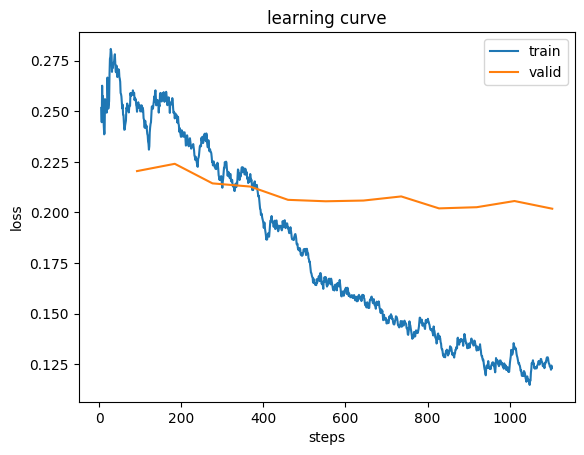

In [32]:
learn_dlr.recorder.plot_loss()